### Applying radial LCE to nT

This is a cleaned up version of the notebook outlining the steps to train the radial LCE

In [2]:
import straxen
import sys, os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba
import tensorflow
import keras
from IPython.display import clear_output
import h5py
import matplotlib

from matplotlib.colors import LogNorm


In [3]:
"""
The following dataset is one large file containing all my data, excluding MC
It is simply data product event info with a seperate column for s2_area_per_channel 
I also appended a number of Cuts as boolean arrays, and a Source Column corresponding to identified events here I do not add the boolean array
The only one relevant to this notebook is the Single Scatter Krypton cut

The Positions column corresponds to x,y positions generated with the flow model 
"""
data_path = '/Code/processed_data/all_data_min_filter.pkl.gz'

all_data_df = pd.read_pickle(data_path, compression='gzip')

bmap = (all_data_df.Source == 'Kr') & (all_data_df.z > -20)

patterns = all_data_df[bmap].loc[:,'s2_area_per_channel']
patterns = np.array(patterns.to_list())
ei = all_data_df[bmap].loc[:, all_data_df.columns != 's2_area_per_channel']
positions = all_data_df[['s2_x', 's2_y']][bmap].to_numpy()

### Function Definitions

In [4]:
def logl_loss_generator(pmt_positions, B, not_dead_pmts = None, cap=float('inf'), allow_njit=True, median_loss = False, check_nan = False, loss_poisson=True):
    """
    Generates a loss function for the specified backend (keras/tensorflow or numpy)
    ------------------------------------------
    pmt_positions : Top array pmt positions (n_pmts, 2) in order x,y
    B : Backend to use, use numpy (module) for numpy and anything else for tf
    not_dead_pmts : Boolean list of alive pmts for filtering
    cap : Maximum loss value
    allow_njit: JIT compiles all functions, using njit for numpy and tf.function (XLA) for tf 
    - No Point for numpy, testing is better but actually using is slower

    - Median_loss -> Absolutely pointless for the small changes im looking at
    """

    if not_dead_pmts is not None:
        n_dof = len(not_dead_pmts) 
        not_dead_pmts_tf = tensorflow.constant(not_dead_pmts, dtype=tensorflow.int32)
    else:
        n_dof = len(pmt_positions)

    # Removing dead pmts -> Assign function to use
    def rem_pmts_tf(ao, ae):
        ao = tensorflow.gather(ao, not_dead_pmts_tf, axis=1)
        ae = tensorflow.gather(ae, not_dead_pmts_tf, axis=1)
        return ao, ae
    def _rem_pmts_np(ao, ae):
        return ao[:, not_dead_pmts], ae[:,not_dead_pmts]
    def no_pmts_missing(ao, ae):
        return ao, ae
    
    if not_dead_pmts is not None:
        if B == np:
            if allow_njit:
                rem_pmts = numba.njit(_rem_pmts_np) 
            else:
                rem_pmts = _rem_pmts_np
        else:
            if allow_njit:
                rem_pmts = tensorflow.function(rem_pmts_tf)
            else:
                rem_pmts = rem_pmts_tf
    else:
        rem_pmts = no_pmts_missing

    def tf_rem_nan(loss):
        # Get rid of nan
        indices = tensorflow.where(tensorflow.math.is_nan(loss))
        return tensorflow.tensor_scatter_nd_update(
            loss,
            indices,
            tensorflow.ones((tensorflow.shape(indices)[0]))*cap
        )
    def np_rem_nan(loss):
        return np.nan_to_num(loss, nan=cap)
    if check_nan:
        np_nan_handle = np_rem_nan
        tf_nan_handle = tf_rem_nan
    else:
        np_nan_handle = lambda X: X
        tf_nan_handle = lambda X: X

    def _loss_np(patterns_true, prediction):
        # Scale prediciton
        patterns_pred = np.reshape(np.sum(patterns_true, axis=1), (-1, 1)) * prediction
        ae = np.clip(patterns_pred, 1e-10, cap) 
        ao = np.clip(patterns_true, 1e-10, cap) 
        ao, ae = rem_pmts(ao, ae)
        loss = np.clip(np.sum((((ao - ae)**2) / ae), axis=1) / n_dof, 0, cap)
        return np_nan_handle(loss)
    def _loss_tensor_standard(patterns_true, prediction):
        patterns_true, prediction = rem_pmts(patterns_true, prediction)
        patterns_pred = tensorflow.reshape(keras.backend.sum(patterns_true, axis=1), (-1, 1)) * prediction / tensorflow.reshape(keras.backend.sum(prediction, axis=1), (-1, 1))
        ae = keras.backend.clip(patterns_pred, 1e-10, cap) 
        ao = keras.backend.clip(patterns_true, 1e-10, cap) 
        loss = tensorflow.clip_by_value(keras.backend.sum((((ao - ae)**2) / ae), axis=1) / n_dof, 0, cap)
        return tf_nan_handle(loss)
    
    def _loss_tensor_poisson(patterns_true, prediction):
        patterns_pred = tensorflow.reshape(keras.backend.sum(patterns_true, axis=1), (-1, 1)) * prediction
        ae = keras.backend.clip(patterns_pred, 1e-10, cap) 
        ao = keras.backend.clip(patterns_true, 1e-10, cap) 
        ao, ae = rem_pmts(ao, ae)
        loss = tensorflow.clip_by_value(2*keras.backend.sum(ao*tensorflow.math.log(ao/ae) - (ao - ae), axis=1) / n_dof, 0, cap)
        return tf_nan_handle(loss)
    
    _loss_tensor = _loss_tensor_poisson if loss_poisson else _loss_tensor_standard
    
    if allow_njit:
        loss_np = numba.njit(_loss_np)
        loss_tf = tensorflow.function(_loss_tensor)
    else:
        loss_np = _loss_np
        loss_tf = _loss_tensor

    # Define which loss function to use
    return loss_np if B == np else loss_tf

# ----------------------------------------------------------------------------

def LCE_model(rho, I0, p, d, a, b):
    return (I0 * ((1 - b) / (1 + (rho / d)**2)**p + a * rho + b))

### Model Definitions

In [5]:
# First the Layers
_scalar_types = (int,float,complex,bool,np.int8,np.int16,np.int32,np.int64,np.uint8,np.uint16,np.uint32,np.uint64,np.float16,np.float32,np.float64,np.complex64,np.complex128,np.bool_)

def norm_angle(theta): #  -pi to pi
    """Truncates angle: -pi to pi"""
    return ((theta + np.pi) % (2 * np.pi)) - np.pi

def sym_angle(theta, B=tensorflow):
    mi = -B.abs(norm_angle(np.pi + theta))
    ma = B.abs(norm_angle(np.pi - theta))
    if B == tensorflow:  return tensorflow.clip_by_value(norm_angle(theta), mi, ma)
    else:                return np.clip(norm_angle(theta), mi, ma)

def positions_to_norm_coords(X, pmt_positions):
    """Convert x, y coordinates to alteranate representations
    Taken from Jelle
    TODO: Returning absolute coordinates
    """
    r_event_tpc = tensorflow.math.sqrt(tensorflow.math.square(X[:, :, 0]) + tensorflow.math.square(X[:, :, 1]))
    
    #X -= pmt_positions
    x, y = X[:, :, 0] - pmt_positions[:,0], X[:, :, 1] - pmt_positions[:,1]
    r_event_pmt = get_r_event_pmt_minimal(x, y)
    q_event_pmt = norm_angle(tensorflow.atan2(y, x) 
                             + np.pi/2
                             - tensorflow.atan2(pmt_positions[:,1], pmt_positions[:,0]))
    
    return keras.backend.stack([
        r_event_pmt,
        # Phi from event to PMT, symmetrized, and suppressed near origin
        sym_angle(q_event_pmt) * r_event_pmt**0.5,
        sym_angle(q_event_pmt + np.pi/2) * r_event_pmt**0.5,
        # Absolute event position
        X[:, :, 0], 
        X[:, :, 1],
        r_event_tpc,
        ], axis=2)

@tensorflow.function
def get_r_event_pmt_minimal(x, y):
    """Get Distance from curr PMT for above func"""
    return tensorflow.math.sqrt(tensorflow.math.square(x) + tensorflow.math.square(y))

@tensorflow.function
def get_r_event_pmt(X, pmt_positions):
    """Get Distance from curr PMT"""
    return tensorflow.math.sqrt(tensorflow.math.square(X[:, :, 0] - pmt_positions[:,0]) + tensorflow.math.square(X[:, :, 1] - pmt_positions[:,1]))



class GetRadius(keras.layers.Layer):
    """
    Computes Radius from input x, y
    """
    def __init__(self, output_shape, pmt_positions, **kwargs):
        super().__init__(**kwargs)
        self._output_shape = output_shape
        self.pmt_positions = pmt_positions
    
    def build(self, input_shape):
        super().build(input_shape)

    @tensorflow.function
    def call(self, X):
        return get_r_event_pmt(X, self.pmt_positions)
    
    def compute_output_shape(self, input_shape):
        return self._output_shape
    
class GetWallDist(keras.layers.Layer):
    """
    Computes Wall Distance from input x, y
    """
    def __init__(self, output_shape, tpc_radius, **kwargs):
        super().__init__(**kwargs)
        self._output_shape = output_shape
        self.tpc_radius = tpc_radius
    
    def build(self, input_shape):
        super().build(input_shape)

    @tensorflow.function
    def call(self, X):
        return self.tpc_radius-tensorflow.sqrt(tensorflow.reduce_sum(tensorflow.square(X), axis=-1))
    
    def compute_output_shape(self, input_shape):
        return self._output_shape
    
class GetFullCoordinateSystem(keras.layers.Layer):
    """
    Computes Radius from input x, y TODO 
    """
    def __init__(self, output_shape, pmt_positions, **kwargs):
        super().__init__(**kwargs)
        self._output_shape = output_shape
        self.pmt_positions = pmt_positions
        self.trainable = False
    
    def build(self, input_shape):
        super().build(input_shape)

    @tensorflow.function
    def call(self, X):
        return positions_to_norm_coords(X, self.pmt_positions)
    
    def compute_output_shape(self, input_shape):
        return self._output_shape

class I0Layer(keras.layers.Layer):
    """Correct response for I0, for each PMT"""
    def __init__(self, n_pmts, init_val=1/77, **kwargs):
        super().__init__(**kwargs)
        self.n_pmts = n_pmts
        self.init_val = init_val 
        # Tensorflwo scalars are really annoying
        if isinstance(init_val,_scalar_types):
            self.scalar_init = True
        elif isinstance(init_val, tensorflow.Tensor):
            if init_val.shape == ():
                self.scalar_init = True
            else:
                self.scalar_init = False
        else:
            self.scalar_init = False

    def build(self, input_shape):
        self.i0 = self.add_weight(
            name='I_0', 
            shape=(self.n_pmts,),
            initializer=keras.initializers.Constant(value=self.init_val if self.scalar_init else 1),
            constraint=keras.constraints.NonNeg(),
            trainable=True)
        super().build(input_shape)
        # Init with pretrained weights
        if ~self.scalar_init: 
            self.i0.weights = self.init_val
    
    @tensorflow.function
    def call(self, X):
        return X * self.i0
    
class NormalizationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        super().build(input_shape)

    def call(self, X):
        X /= keras.backend.reshape(keras.backend.sum(X, axis=1), (-1, 1))
        return X
    
    def compute_output_shape(self, input_shape):
        return input_shape
    

class RadialLCELayer(keras.layers.Layer):
    """Compute radial LCE
    
    Wall terms keep failing the fit 

    Input (n_patterns, n_pmts), rho
    Output (n_patterns, n_pmts) with LCE/PMT
    """
    def __init__(self, guess, n_groups, group_slices,**kwargs):
        super().__init__(**kwargs)
        # Decay + fudge
        self.guess = guess
        self.n_groups = n_groups
        self.group_slices = tensorflow.ragged.constant(group_slices, dtype=tensorflow.int32)
        if n_groups == 1:
            # Debug leftover, but should be quicker
            self.call = self.single_group_call
        else:
            self.call = self.multi_group_call
        
        self.call = tensorflow.function(self.call)
        return 
    
    
    def lce_map(self,rho, p, d, a, b):
        # Last parameter filled role of linear addition and multiplier -> Pointless removed
        # Not sure using tensorflow funcs actually makes thsi faster or just less legible
        # also I came when i removed c to test something I+1 was easier than finding all the invocations
        return (
             tensorflow.math.divide((1 - b), tensorflow.math.pow((1 + tensorflow.math.square(rho/d)), p) )
            + tensorflow.math.multiply(a,  rho )
            + b
        )
    
    def build(self, input_shape):
        self.params = self.add_weight(
            name='lce_params', 
            shape=(self.n_groups, len(self.guess)),
            initializer=keras.initializers.Constant(
                np.array(self.guess * self.n_groups).reshape(self.n_groups, len(self.guess))),
                trainable=True)
        super().build(input_shape)

    def multi_group_call(self, X, training=None):        
        """Something here is broken """
        def process_group(group_idx, shape):
            # Select group
            group_indices = self.group_slices[group_idx]
            group_X = tensorflow.gather(X, group_indices, axis=1)
            # Need to pass group parameters explicitly 
            gp = self.params[group_idx, :len(self.guess)]
            # Apply Op
            res = self.lce_map(group_X, gp[0],gp[1],gp[2],gp[3])
            # We now need to generate the parameters to return a sparse matrix 
            batch_size = tensorflow.shape(res)[0]
            n_indices = len(group_indices)  
            # Generate one row per batch, with the batch idx (so for batch isze 256 contains 256 [i,i,i] with i in 0 255 )
            batch_indices = tensorflow.tile(tensorflow.range(batch_size)[:, tensorflow.newaxis], [1, n_indices])
            # Generate a list with first dime batch size and second n_indcs with the indcs as elements
            column_indices = tensorflow.tile(group_indices[tensorflow.newaxis, :], [batch_size, 1]) 
            # We stack the two together to get shape (batch_size, n_indeces, 2) < - last dim fully specifies pos within batch and which batch
            # This si since tf uses the flattened versions internaly
            indices = tensorflow.stack([batch_indices, column_indices], axis=-1)
            return tensorflow.scatter_nd(indices, res, shape)
        def process_all_groups(X):
            combined_result = tensorflow.zeros_like(X)
            # Assign for each group idx 
            shape = tensorflow.shape(combined_result)
            group_indeces = tensorflow.range(self.n_groups)  
            def per_group(group_idx):
                return process_group(group_idx, shape)
            # Cant do for loop with tf.function
            group_result = tensorflow.map_fn(per_group, group_indeces, dtype=X.dtype)
            # We have a 1 D higher dimensional sparse matrix
            combined_result = tensorflow.reduce_sum(group_result,axis=0)
            #for group_idx in tensorflow.range(tensorflow.shape(self.group_slices)[0]):
            #    combined_result += process_group(group_idx,shape)
            return combined_result
        return process_all_groups(X)
    
    def single_group_call(self, X, training=None):
        """
        Debug function as loss's are on order e16
        """
        gp = self.params[0, :len(self.guess)]
        return self.lce_map(X, gp[0],gp[1],gp[2],gp[3])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])




# Now Model Generators ---------------------------------------------------------

def get_full_LCE_coordinate_model(n_pmts, pmt_positions, n_pmt_pos = 6):
    """
    Generates all coordinates we will require later
    """
    conv_pmt_coords = keras.models.Sequential([
        keras.layers.RepeatVector(n_pmts, input_shape=(2,)),
        GetFullCoordinateSystem((n_pmts, n_pmt_pos), keras.backend.variable(pmt_positions))
    ], name='xy_to_pmt_coords')
    return conv_pmt_coords
def get_minimal_LCE_coordinate_model(n_pmts, pmt_positions, n_pmt_pos = 1):
    """
    Generate's PMT Position coordinate, the main one used for now
    """
    conv_pmt_coords = keras.models.Sequential([
        keras.layers.RepeatVector(n_pmts, input_shape=(2,)),
        GetRadius((n_pmts, n_pmt_pos), keras.backend.variable(pmt_positions)),
    ], name='xy_to_pmt_coords')
    return conv_pmt_coords

def get_RLCEModel(pmt_pos_top,n_pmts, n_groups, group_slices, I0_init, guess,**kwargs):
    """
    Generate Radial LCE Model for fitting
    kwargs -> Overflow from old variables
    """
    # Input layer
    input_pos = keras.layers.Input(shape=(2))
    # Get different coordinates
    rho = get_minimal_LCE_coordinate_model(n_pmts = n_pmts, pmt_positions = pmt_pos_top, n_pmt_pos = 1)(input_pos)
    # Apply radial lce 
    m = RadialLCELayer(name='radial_lce',guess= guess, n_groups=n_groups, group_slices=group_slices)(rho)
    
    # Holds I0 for each PMT
    m = I0Layer(n_pmts, init_val= tensorflow.cast(I0_init, tensorflow.float32), name='QE_Layer')(m)
    # Normalization Layer 
    m = NormalizationLayer(name='Normalization')(m)
    return keras.models.Model(inputs=input_pos, outputs=m, name="Radial_LCE")

def get_neural_LCE(n_pmts, pmt_pos, I0_init=0.1, activation ='relu', final_activation='sigmoid'):
    input = keras.layers.Input(shape=(2))
    # Model to generate relevant coordinates
    m = get_full_LCE_coordinate_model(n_pmts, pmt_pos, n_pmt_pos = 6)(input)
    m = keras.layers.Conv1D(filters=60, kernel_size=1, activation=activation)(m)
    m = keras.layers.Conv1D(filters=30, kernel_size=1, activation=activation)(m)
    m = keras.layers.Conv1D(filters=15, kernel_size=1, activation=activation)(m)
    m = keras.layers.Conv1D(filters=15, kernel_size=1, activation=activation)(m)
    m = keras.layers.Conv1D(filters=1, kernel_size=1, activation=final_activation)(m)
    m = keras.layers.Flatten()(m)
    # Add I0 and normalization layers
    m = I0Layer(n_pmts, init_val= I0_init, name='QE_Layer')(m)
    m = NormalizationLayer()(m)
    return keras.Model(inputs=input, outputs=m, name='neural_lce')

def get_position_updater(positions, n_to_update, model,input_len = 1, embeddings_constraint=[]):
    """
    Returns encoder model to get patterns from positions
    """
    input = keras.layers.Input(shape=(input_len,))
    if embeddings_constraint != []:
        m = keras.layers.Embedding(n_to_update, 2, input_length = input_len, name='embed_pos',embeddings_constraint=embeddings_constraint)(input)
    else: 
        m = keras.layers.Embedding(n_to_update, 2, input_length = input_len, name='embed_pos')(input)
    m = keras.layers.Flatten()(m)
    m = model(m)
    pos_updater = keras.models.Model(inputs= input, outputs=m, name="Position_Updater")
    pos_updater.layers[-1].trainable = False
    pos_updater.get_layer('embed_pos').set_weights([positions[:n_to_update]])

    return pos_updater

# Apply Position updater
def train_and_update_pos(positions, patterns, model, n_iter = 5, verbose=0, hist_pos=False, keras_loss=None):
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(
        monitor='loss',
        restore_best_weights=True,
        patience=4,    
        min_delta=0.05,
        mode='min',    
        verbose=1      
    )
    reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(
        monitor='loss', 
        mode = 'min',
        factor=0.5,     
        patience=2,     
        min_delta=0.05, 
        min_lr=1e-3,    
        verbose=1       
    )
    n_tot = len(positions)
    pos_updater = get_position_updater(positions, n_tot, model ,input_len = 1)
    # Inspecting the degree of change
    if hist_pos:
        trained_pos = []

    new_pos = tensorflow.identity(positions)
    loss    = keras_loss(patterns, model.predict(positions))
    improved= np.zeros(positions.shape[0])
    improved[:] = -1
    for i in range(n_iter):
        print("Jagged iter {}".format(i))
        # tensorflow_probability requires tensorflow >= 2.16 we have == 2.15
        # Random dist gives max deviation root{2}*pmt_radius (~70% of diameter)
        noise_pos = tensorflow.identity(positions) + np.random.rand(*new_pos.numpy().shape) * pmt_radius
        # Update and fit encoder model positions
        pos_updater.get_layer('embed_pos').set_weights([noise_pos])
        # Compile and fit
        pos_updater.compile(loss= keras_loss, optimizer = keras.optimizers.Adam(learning_rate=1e-1))
        pos_updater.fit(x = np.arange(n_tot), y = patterns, 
                        epochs = 20, batch_size = 2**12,
                        callbacks=[early_stopping,reduce_lr], verbose = verbose) 
        noise_pos = pos_updater.get_layer('embed_pos').get_weights()[0]
        # Check result of new pos
        jittered_loss = keras_loss(patterns, model.predict(noise_pos, verbose=verbose))

        better = jittered_loss < loss
        loss =    tensorflow.where(better, jittered_loss, loss) 
        new_pos = tensorflow.where(tensorflow.expand_dims(better, axis=-1), noise_pos, new_pos) 
        improved[better.numpy()] = i
        if hist_pos:
            trained_pos.append(noise_pos)

    print("Jittering Results")
    print("Didnt improve : {}%".format((improved == -1).mean()*100))
    for i in range(n_iter):
        print("Iteration {} : {}%".format(i, (improved == i).mean()*100))
    if not hist_pos:
        return new_pos
    else:
        return new_pos, trained_pos


# And Plotting Functions -------------------------------------------------------

def plot_loss_histogram(model, dat, val, loss_func, bins=50, ax=None, title = 'Histogram of Loss for Validation and Testing Datasets'):
    """GPT made this
    Plots a histogram of the loss values for both validation and testing data.
    
    Parameters:
    - model: Trained Keras model used for predictions.
    - validation_slice: A slice or index array for selecting the validation set.
    - testing_slice: A slice or index array for selecting the testing set.
    - x_data: The input dataset (features).
    - y_data: The ground truth dataset (targets).
    - bins: The number of bins for the histogram.
    """
    
    # Get validation and testing data
    x_val, y_val = val
    x_test, y_test = dat

    # Predict using the model for validation and test data
    y_val_pred = model.predict(x_val, verbose=0) 
    y_test_pred = model.predict(x_test, verbose=0)

    # Calculate loss (using mean squared error as an example)
    val_losses = loss_func(y_val, y_val_pred)
    test_losses = loss_func(y_test, y_test_pred)

    # Create the histogram plot
    if ax is None:
        plt.figure(figsize=(10, 6))
    else:
        plt.sca(ax)

    # Plot for validation loss
    hist, bins_ = np.histogram(val_losses, bins=bins)
    logbins = np.logspace(np.log10(bins_[0]),np.log10(bins_[-1]),len(bins_))
    plt.hist(val_losses, bins=logbins, alpha=0.5, label='Validation Loss', color='blue')

    # Plot for testing loss
    hist, bins_ = np.histogram(test_losses, bins=bins)
    logbins = np.logspace(np.log10(bins_[0]),np.log10(bins_[-1]),len(bins_))
    plt.hist(test_losses, bins=logbins, alpha=0.5, label='Training Loss', color='orange')
    plt.axvline(1, c='r', linestyle='dotted')
    med = np.sort(np.concatenate([val_losses, test_losses]))[(len(val_losses) + len(test_losses)) //2]
    plt.axvline(med, c='g', label='median {:.3}'.format(med))
    plt.xscale('log')
    plt.yscale('log')
    # Add labels and title
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.title(title)
    #plt.xlim(left=0.1)
    # Add a legend
    plt.legend(loc='upper right')
    # Show the plot
    if ax is None:
        plt.show()
    return val_losses, test_losses

def do_density_plot(ax, pos,title='',bins=100):
    radius = np.abs(np.max(pos))
    x_edges = y_edges = np.linspace(-radius, radius, bins)
    hist, xedges, yedges = np.histogram2d(pos[:, 0], pos[:, 1], bins=[x_edges, y_edges])
    im = ax.imshow(hist.T, origin='lower', extent=[-radius, radius, -radius, radius], cmap='viridis')
    plt.colorbar(im, label='Density', ax=ax)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(title)
    return ax


def plot_pmt_response(pmt_pos, response, ax=None, title=None, vmin=None, vmax=None, logscale=False, dead_pmts=None, mark_spot=None, secondary_response=None, text=None, cmap=plt.cm.viridis):
    from matplotlib.patches import Wedge
    # Misc
    radius = 3 * 2.54 / 2
    if isinstance(pmt_pos, pd.DataFrame):
        _pmt_pos = pmt_pos.to_numpy()
    else:
        _pmt_pos = pmt_pos

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    # Primary response normalization
    if not logscale:
        primary_normalizer = plt.Normalize
        _response = response
    else:
        primary_normalizer = matplotlib.colors.LogNorm
        _response = response.copy()
        _response[_response < 1] = vmin if vmin is not None else 1
    
    # Secondary response normalization
    if secondary_response is not None:
        if not logscale:
            secondary_normalizer = plt.Normalize
            _secondary_response = secondary_response
        else:
            secondary_normalizer = matplotlib.colors.LogNorm
            _secondary_response = secondary_response.copy()
            _secondary_response[_secondary_response < 1] = vmin if vmin is not None else 1
    # Plot dead PMTs and remove them from the list
    if dead_pmts is not None:
        for i in dead_pmts:
            circle = plt.Circle((_pmt_pos[i, -2], _pmt_pos[i, -1]), radius, color='grey', fill=True)
            ax.add_artist(circle)
        mask = np.ones(pmt_pos.shape[0], dtype=bool)
        mask[dead_pmts] = False
        _pmt_pos = _pmt_pos[mask]
        _response = _response[mask]
        if secondary_response is not None: _secondary_response = _secondary_response[mask]

    primary_norm = primary_normalizer(vmin=_response.min() if vmin is None else vmin,
                                       vmax=_response.max() if vmax is None else vmax)
    if secondary_response is not None:
        secondary_norm = secondary_normalizer(vmin=_secondary_response.min() if vmin is None else vmin,
                                              vmax=_secondary_response.max() if vmax is None else vmax)
    # Plot circles with response
    for i in range(len(_pmt_pos)):
        # Primary response color
        primary_response_color = cmap(primary_norm(_response[i]))
        if secondary_response is not None:
            # Wedge for primary response (half)
            primary_wedge = Wedge((_pmt_pos[i, -2], _pmt_pos[i, -1]), radius, 45, 225, color=primary_response_color, fill=True)
            ax.add_artist(primary_wedge)
            # Secondary response color
            secondary_response_color = cmap(secondary_norm(_secondary_response[i]))
            # Wedge for secondary response (half)
            secondary_wedge = Wedge((_pmt_pos[i, -2], _pmt_pos[i, -1]), radius, 225, 405, color=secondary_response_color, fill=True)
            ax.add_artist(secondary_wedge)
        else:
            # Full circle for primary response
            circle = plt.Circle((_pmt_pos[i, -2], _pmt_pos[i, -1]), radius, color=primary_response_color, fill=True)
            ax.add_artist(circle)

    # Colorbar for primary response
    sm_primary = plt.cm.ScalarMappable(cmap=cmap, norm=primary_norm)
    sm_primary.set_array([])  # ScalarMappable requires a dummy array
    cbar_primary = plt.colorbar(sm_primary, ax=ax)

    # Colorbar for secondary response
    if secondary_response is not None:
        sm_secondary = plt.cm.ScalarMappable(cmap=cmap, norm=secondary_norm)
        sm_secondary.set_array([])  # ScalarMappable requires a dummy array
        cbar_secondary = plt.colorbar(sm_secondary, ax=ax)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X position (cm)')
    ax.set_ylabel('Y position (cm)')
    ax.set_xlim([_pmt_pos[:, -2].min() - 10, _pmt_pos[:, -2].max() + 10])
    ax.set_ylim([_pmt_pos[:, -1].min() - 10, _pmt_pos[:, -1].max() + 10])
    if mark_spot is not None:
        ax.scatter(mark_spot[0], mark_spot[1], c='r', marker='x')
    if title is not None:
        ax.set_title(title)

    if text is not None:
        for key in text:
            add_scalable_text(ax, text[key], location="bottom_right")

    return ax

def add_scalable_text(ax, text, location="bottom_right"):
    bbox = ax.get_window_extent()
    width, height = bbox.width, bbox.height
    font_size = min(width, height) * 0.04
    # Set text position based on specified location
    if location == "bottom_right":
        x, y = 0.8, 0.025  # Adjusted for bottom right
    elif location == "bottom_left":
        x, y = 0.01, 0.025
    elif location == "top_right":
        x, y = 0.8, 0.875
    elif location == "top_left":
        x, y = 0.01, 0.875

    # Add text to the plot, scaling font size with figure size
    ax.text(x, y, text, ha="center", va="center",
            fontsize=font_size,  # Scales with figure size
            transform=ax.transAxes, wrap=True)

### Load Misc

In [6]:
# Now we need some variables
pmt_pos = straxen.pmt_positions()
pmt_pos_top = pmt_pos[pmt_pos.array == "top"].to_numpy()
n_pmts = pmt_pos_top.shape[0]
# In case this wasnt the the data still includes bottom PMTs
patterns = patterns[:, :n_pmts]

tpc_radius = 66.4
max_z = straxen.tpc_z
pmt_radius = straxen.tpc_pmt_radius
dead_pmts =     np.argwhere(patterns[:100].mean(axis=0) == 0).reshape(-1)
not_dead_pmts = np.argwhere(patterns[:100].mean(axis=0) != 0).reshape(-1)

n_datapoints = ei.shape[0]

# Generate Loss Function
allow_njit = True
keras_loss = logl_loss_generator(pmt_pos_top, keras.backend, not_dead_pmts = not_dead_pmts, cap=float('inf'), allow_njit=allow_njit)

if allow_njit:
    keras_loss(np.random.random((1, n_pmts)),np.random.random((1, n_pmts)))


np.random.seed(1111)
shuffle_i = np.arange(n_datapoints)
np.random.shuffle(shuffle_i)
train_end = int(n_datapoints * 0.8)
train_slice = shuffle_i[0:train_end]
val_slice = shuffle_i[train_end:]


### Basics

In [7]:
# Fit LCE function based on PMT response 

def tmp():
    #pmtnr = 126
    from scipy.optimize import curve_fit
    fparams = np.zeros((n_pmts, 5))
    covar = []
    
    for pmtnr in not_dead_pmts:
        event_dist = ((positions - pmt_pos_top[pmtnr, -2:])**2).sum(axis=-1)**(1/2)
        tmp = patterns[:,pmtnr] / patterns.sum(axis=-1)
        mask_tmp = ~((tmp == float('inf')) | (tmp == -float('inf')) | (np.isnan(tmp)))

        initial_guess = [patterns[:,pmtnr].max(), 1.6242546e+00,  9.4928885e+00, -3.8433252e-05,  7.8334948e-03]
        params, covariance = curve_fit(
                    LCE_model, event_dist[mask_tmp], tmp[mask_tmp], p0=initial_guess, 
        )
        fparams[pmtnr] = params
        covar.append(covariance)

    return np.array(fparams), covar

fparams, covar = tmp()

Fitted parameters:
I0 = 0.11082790703063464, a = -0.00011679226621043185, b = 0.016026822324761176, d = 12.732297509124294, p = 2.3037296800926828
Fitted parameters:
I0 = 0.1420477608283031, a = -6.452072820033453e-05, b = 0.010942065933765815, d = 11.03912578455912, p = 1.879162923708078
Fitted parameters:
I0 = 0.12751581328173733, a = -4.984675534024035e-05, b = 0.008760873217443843, d = 9.491701172952423, p = 1.674460912394075


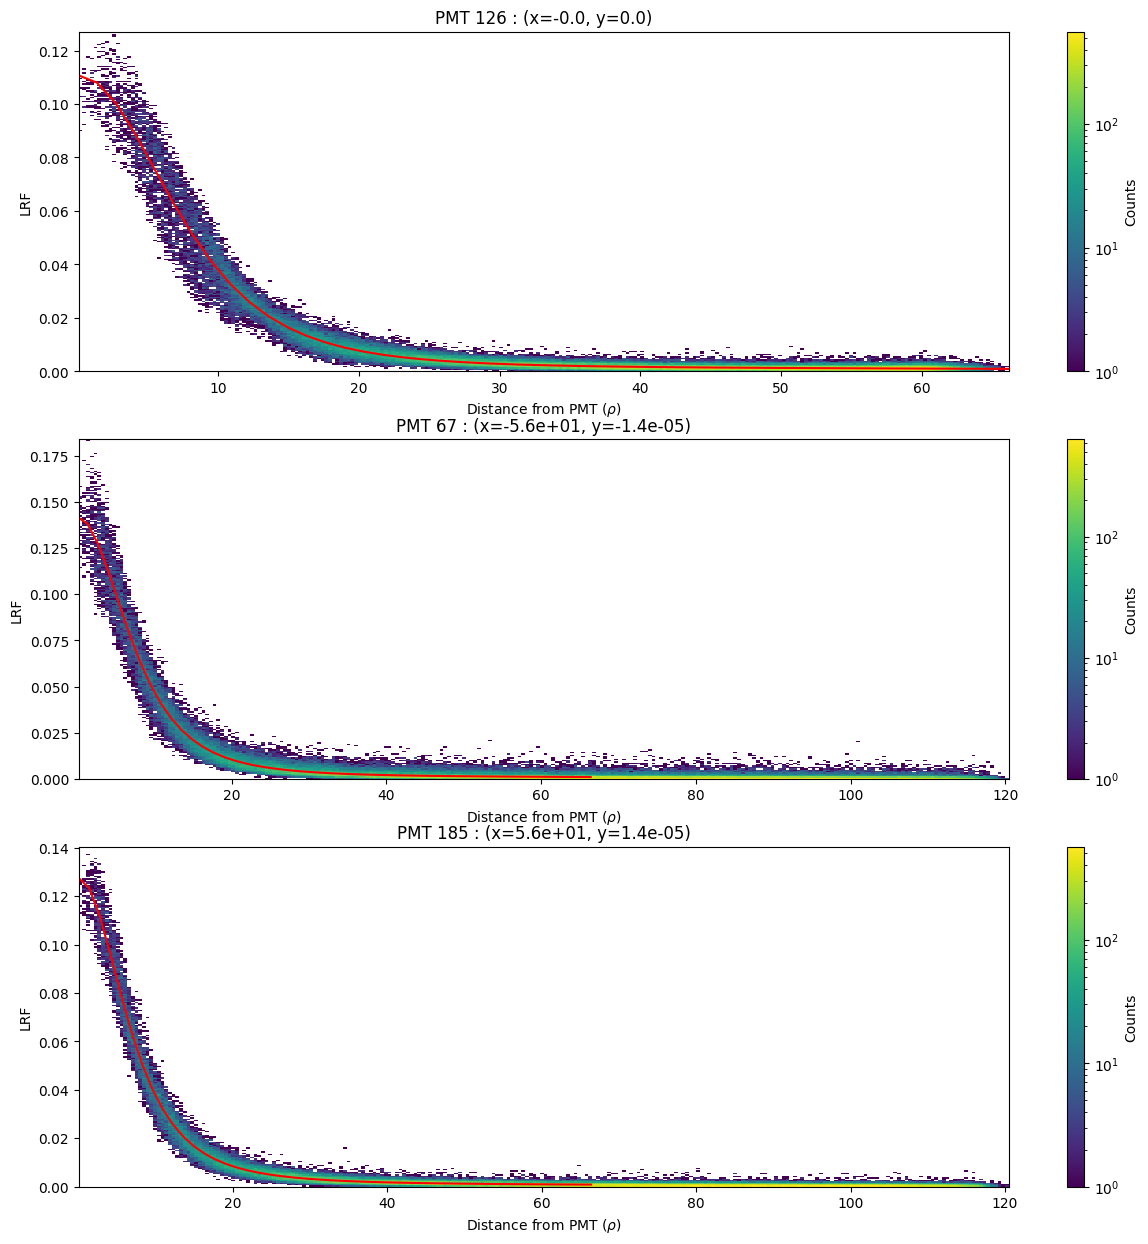

In [8]:
from matplotlib.colors import LogNorm

fig,ax = plt.subplots(3,1, figsize=(15,15))

x = np.linspace(0,tpc_radius)

# Center, left wall, right wall
pmtnr = [126, 67, 185]

for i in range(len(pmtnr)):
    event_dist = ((positions - pmt_pos_top[pmtnr[i], -2:])**2).sum(axis=-1)**(1/2)
    tmp = patterns[:,pmtnr[i]] / patterns.sum(axis=-1)
    mask_tmp = ~((tmp == float('inf')) | (tmp == -float('inf')) | (np.isnan(tmp)))
    hist = ax[i].hist2d(event_dist[mask_tmp], tmp[mask_tmp], bins=250, norm=LogNorm())
    plt.colorbar(hist[3],ax=ax[i], label="Counts")
    params = fparams[pmtnr[i]]
    ax[i].plot(x, LCE_model(x, *params), label="Data", color="red")

    I0_fit,p_fit, d_fit, a_fit, b_fit,  = params
    print("Fitted parameters:")
    print(f"I0 = {I0_fit}, a = {a_fit}, b = {b_fit}, d = {d_fit}, p = {p_fit}")
    ax[i].set_title("PMT {} : (x={:.2}, y={:.2})".format(pmtnr[i], *pmt_pos_top[pmtnr[i],-2:]))
    ax[i].set_ylabel('LRF')
    ax[i].set_xlabel(r"Distance from PMT ($\rho$)")
    ax[i].set_ylim(0)

plt.show()

Minimal uniform I0 0.0040650406504065045, chi^2/ndf : 60.87712860107422


0.0040650406504065045

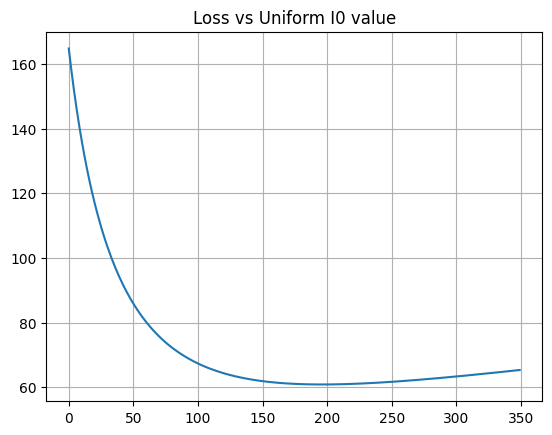

In [9]:
# Get I0 for which gloabal average is at its minimum (Predicts constant across all)

def UniformLCE():
    min_val = 50
    max_val = 400
    patterns_tmp = tensorflow.gather(patterns, val_slice, axis=0)
    tst = [tensorflow.math.reduce_mean(keras_loss(patterns_tmp, tensorflow.ones((len(val_slice), n_pmts), dtype=tensorflow.float32)/i)) for i in range(min_val,max_val)]
    tst_no_nan = tensorflow.where(tensorflow.math.is_nan(tst), tensorflow.constant(float('inf')), tst)
    minidx = tensorflow.argmin(tst_no_nan)
    I0_init_from_ULCE = 1/[i for i in range(min_val,max_val)][minidx]
    plt.plot(tst)
    #plt.axvline(minidx, linestyle = 'dashed',c='r')
    #plt.axhline(tst[minidx], linestyle = 'dashed',c='r')
    plt.grid()
    plt.title("Loss vs Uniform I0 value")
    print("Minimal uniform I0 {}, chi^2/ndf : {}".format(I0_init_from_ULCE, tst[minidx]))  
    return I0_init_from_ULCE
I0_init_from_ULCE = UniformLCE()
I0_init_from_ULCE

## Train rLCE for a single PMT Group 

I will just start of with something close to the best found parameters for the radial LCE

Epoch 1/100
566/566 [==============================] - 3s 5ms/step - loss: 2.1128 - val_loss: 2.0792 - lr: 5.0000e-06
Epoch 2/100
566/566 [==============================] - 2s 3ms/step - loss: 2.0753 - val_loss: 2.0718 - lr: 5.0000e-06
Epoch 3/100
556/566 [============================>.] - ETA: 0s - loss: 2.0721
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
566/566 [==============================] - 2s 3ms/step - loss: 2.0721 - val_loss: 2.0705 - lr: 5.0000e-06
Epoch 4/100
566/566 [==============================] - 3s 6ms/step - loss: 2.0716 - val_loss: 2.0706 - lr: 2.5000e-06
Epoch 5/100
547/566 [===========================>..] - ETA: 0s - loss: 2.0715
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
566/566 [==============================] - 3s 5ms/step - loss: 2.0715 - val_loss: 2.0702 - lr: 2.5000e-06
Epoch 6/100
566/566 [==============================] - 2s 3ms/step - loss: 2.0713 - val_loss: 2.0702 - lr: 1.2500e-06
Epoch 6:

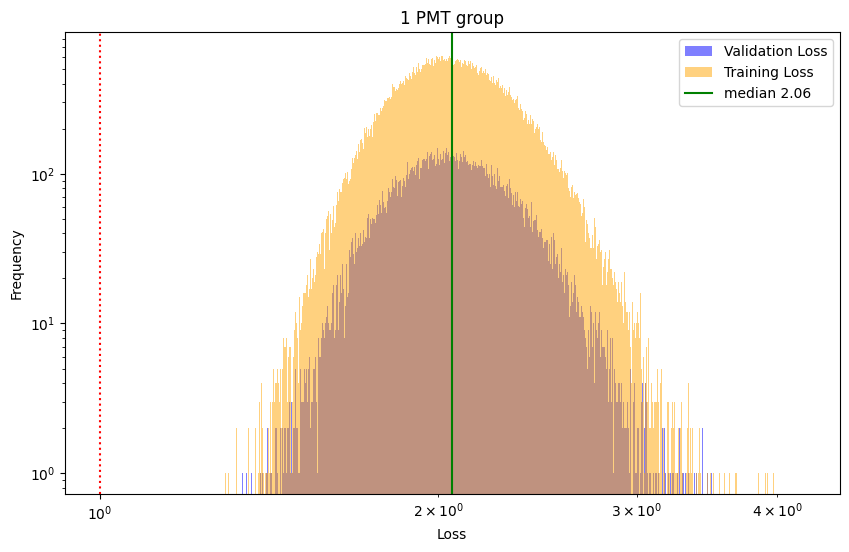

In [22]:
rLCE_params = [1.6266745e+00,  9.4918861e+00, -4.2176653e-05,  7.7804564e-03,]

x_train = positions[train_slice]
y_train = patterns[train_slice]
val = (positions[val_slice], patterns[val_slice])

radial_lce = get_RLCEModel(pmt_pos_top[:,2:],n_pmts=n_pmts, n_groups=1, group_slices=np.arange(n_pmts), 
                        I0_init=I0_init_from_ULCE, guess = rLCE_params)

early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,        
    restore_best_weights=True,
    min_delta=0.02,
    mode='min',    
    verbose=1      
)
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode = 'min',
    restore_best_weights=True,
    factor=0.5,           
    patience=2,            
    min_delta=0.02,        
    min_lr=1e-8,           
    verbose=1              
)

radial_lce.compile(loss= keras_loss, optimizer = keras.optimizers.Adam(learning_rate=5e-6))
radial_lce.fit(x = x_train, y = y_train, 
            validation_data=val,
            epochs = 100, batch_size = 2**8, 
            callbacks=[early_stopping, reduce_lr])

val_loss, train_loss = plot_loss_histogram(radial_lce, (x_train, y_train), val, ax=None, loss_func=keras_loss, bins=1000,
                        title= "1 PMT group")


In [23]:
# Apply Encoder 

new_pos=train_and_update_pos(positions, patterns, radial_lce, n_iter = 4, verbose=1, hist_pos=False,keras_loss=keras_loss)

5652/5652 [==============================] - 4s 754us/step
Jagged iter 0
Epoch 1/20
45/45 [==============================] - 1s 11ms/step - loss: 3.6184 - lr: 0.1000
Epoch 2/20
45/45 [==============================] - 0s 11ms/step - loss: 3.0419 - lr: 0.1000
Epoch 3/20
45/45 [==============================] - 1s 11ms/step - loss: 2.6380 - lr: 0.1000
Epoch 4/20
45/45 [==============================] - 0s 11ms/step - loss: 2.3810 - lr: 0.1000
Epoch 5/20
45/45 [==============================] - 1s 11ms/step - loss: 2.2293 - lr: 0.1000
Epoch 6/20
45/45 [==============================] - 1s 11ms/step - loss: 2.1455 - lr: 0.1000
Epoch 7/20
45/45 [==============================] - 1s 11ms/step - loss: 2.1017 - lr: 0.1000
Epoch 8/20
45/45 [==============================] - 1s 11ms/step - loss: 2.0802 - lr: 0.1000
Epoch 9/20
45/45 [==============================] - 1s 11ms/step - loss: 2.0702 - lr: 0.1000
Epoch 10/20
41/45 [==========================>...] - ETA: 0s - loss: 2.0661
Epoch 10: Redu

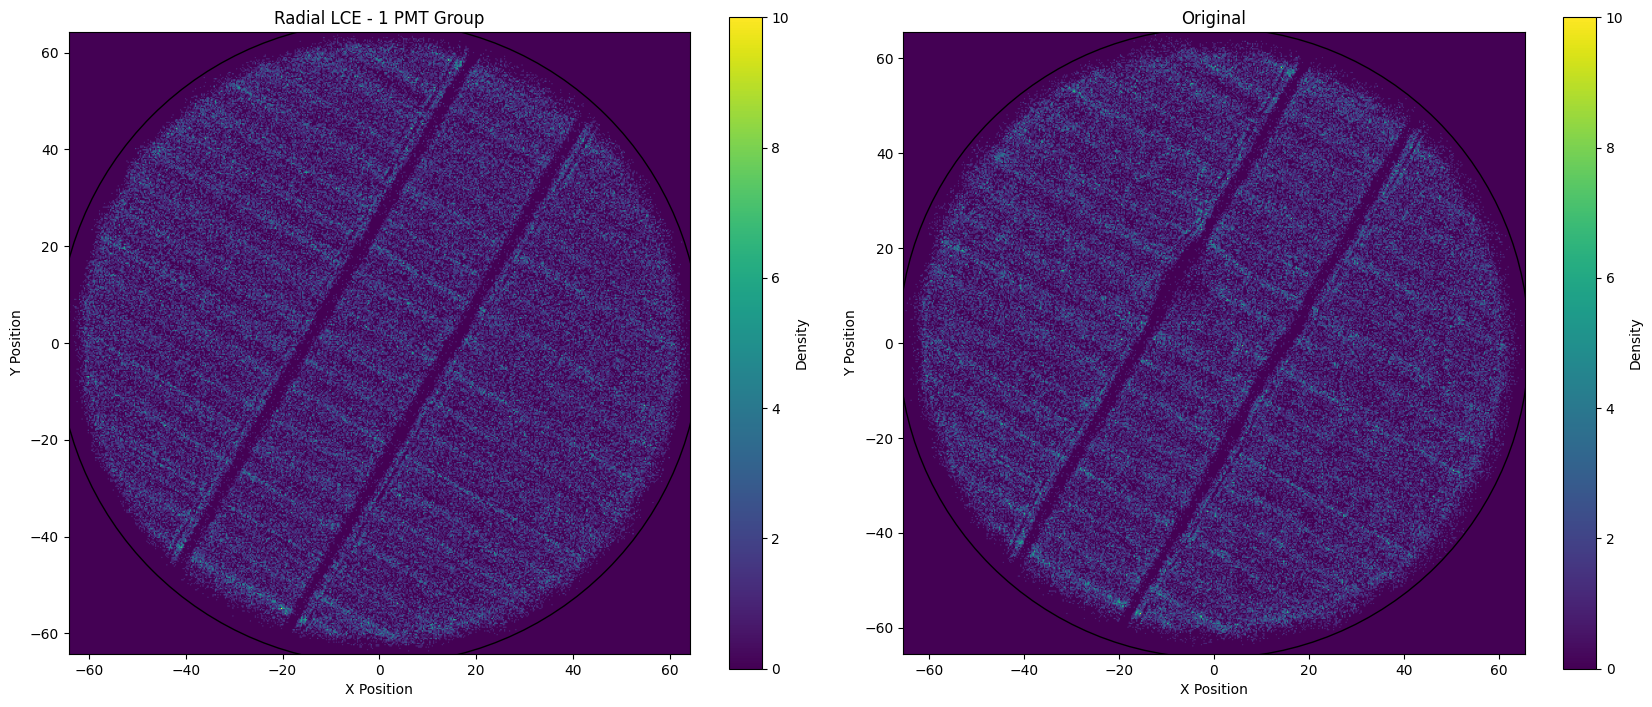

In [26]:
fig, ax = plt.subplots(1,2,figsize=(17,7))

do_density_plot(ax[0],new_pos, title='Radial LCE - 1 PMT Group', bins=500)
do_density_plot(ax[1],positions, title='Original', bins=500)
circle = plt.Circle((0, 0), tpc_radius, color='black', fill=False)
ax[0].add_patch(circle)
circle = plt.Circle((0, 0), tpc_radius, color='black', fill=False)
ax[1].add_patch(circle)

plt.tight_layout()

In [25]:
# New Median

tmp = keras_loss(patterns, radial_lce.predict(new_pos))
print(np.sort(tmp)[len(tmp)//2])

5652/5652 [==============================] - 4s 759us/step
2.031949


## Train rLCE for a as many PMT Groups as there are alive PMTs 

Instructions for updating:
Use fn_output_signature instead
Epoch 1/100
566/566 [==============================] - 31s 53ms/step - loss: 2.0928 - val_loss: 2.0625 - lr: 5.0000e-06
Epoch 2/100
566/566 [==============================] - 28s 50ms/step - loss: 2.0592 - val_loss: 2.0546 - lr: 5.0000e-06
Epoch 3/100
565/566 [============================>.] - ETA: 0s - loss: 2.0543
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
566/566 [==============================] - 28s 50ms/step - loss: 2.0543 - val_loss: 2.0520 - lr: 5.0000e-06
Epoch 4/100
566/566 [==============================] - 28s 49ms/step - loss: 2.0508 - val_loss: 2.0494 - lr: 2.5000e-06
Epoch 5/100
565/566 [============================>.] - ETA: 0s - loss: 2.0503
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
566/566 [==============================] - 28s 49ms/step - loss: 2.0503 - val_loss: 2.0490 - lr: 2.5000e-06
Epoch 6/100
566/566 [==============================] - 28

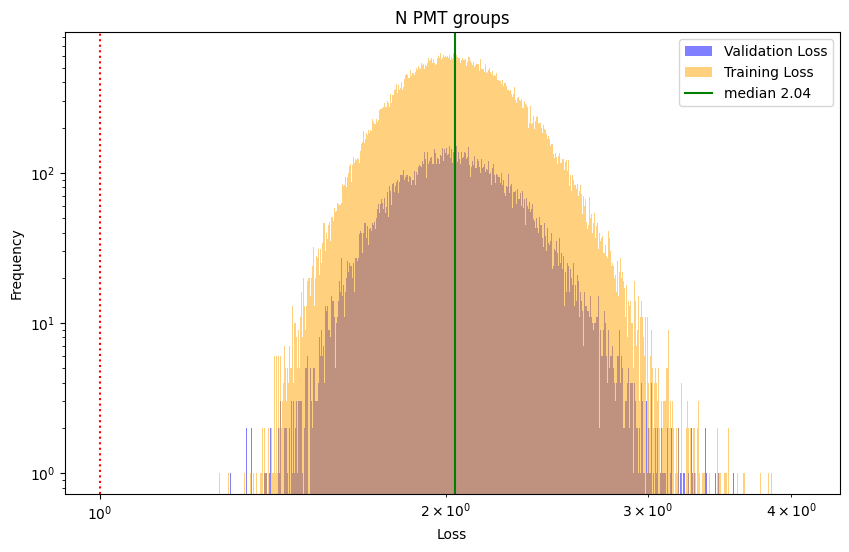

In [14]:
rLCE_params = [1.6266745e+00,  9.4918861e+00, -4.2176653e-05,  7.7804564e-03,]

x_train = positions[train_slice]
y_train = patterns[train_slice]
val = (positions[val_slice], patterns[val_slice])

radial_lce = get_RLCEModel(pmt_pos_top[:,2:],n_pmts=n_pmts, n_groups=n_pmts, group_slices=np.arange(n_pmts).reshape(-1,1), 
                        I0_init=I0_init_from_ULCE, guess = rLCE_params)

early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,        
    restore_best_weights=True,
    min_delta=0.02,
    mode='min',    
    verbose=1      
)
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode = 'min',
    restore_best_weights=True,
    factor=0.5,           
    patience=2,            
    min_delta=0.02,        
    min_lr=1e-8,           
    verbose=1              
)

radial_lce.compile(loss= keras_loss, optimizer = keras.optimizers.Adam(learning_rate=5e-6))
radial_lce.fit(x = x_train, y = y_train, 
            validation_data=val,
            epochs = 100, batch_size = 2**8, 
            callbacks=[early_stopping, reduce_lr])

val_loss, train_loss = plot_loss_histogram(radial_lce, (x_train, y_train), val, ax=None, loss_func=keras_loss, bins=1000,
                        title= "N PMT groups")


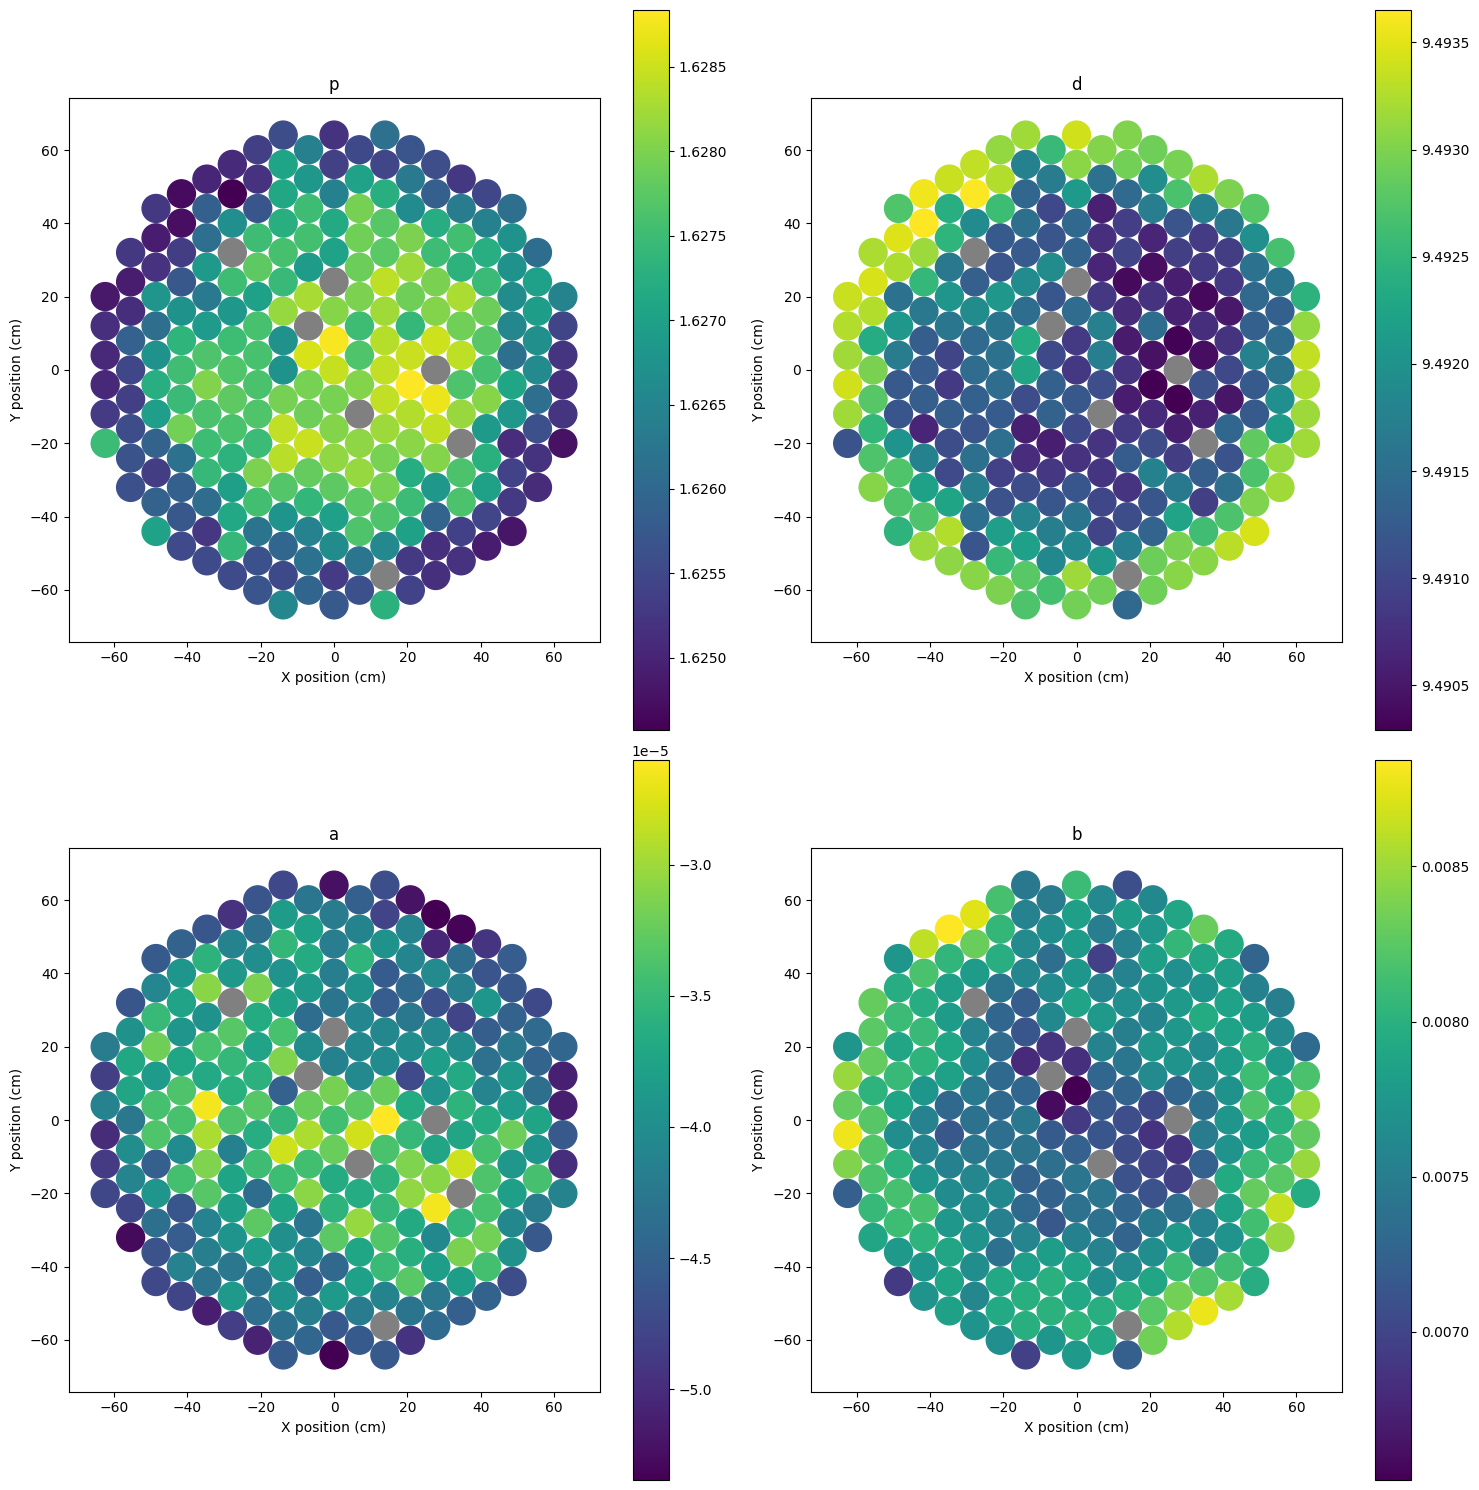

In [15]:
titles = ['p', 'd', 'a', 'b']
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax = ax.flatten()
for i in range(4):
    plot_pmt_response(pmt_pos_top, radial_lce.get_layer('radial_lce').weights[0][:,i].numpy(), ax = ax[i], title=titles[i], vmin=None, vmax=None, logscale=False, dead_pmts = dead_pmts, mark_spot=None, )
#plot_pmt_response(pmt_pos_top, radial_lce.get_layer('QE_Layer').weights[0].numpy(), ax = ax[-1], title='I0', vmin=None, vmax=None, logscale=False, dead_pmts = dead_pmts, mark_spot=None, )
plt.tight_layout()

In [16]:
new_pos=train_and_update_pos(positions, patterns, radial_lce, n_iter = 4, verbose=1, hist_pos=False,keras_loss=keras_loss)

5652/5652 [==============================] - 48s 9ms/step
Jagged iter 0
Epoch 1/20
45/45 [==============================] - 13s 281ms/step - loss: 3.6190 - lr: 0.1000
Epoch 2/20
45/45 [==============================] - 12s 273ms/step - loss: 3.0380 - lr: 0.1000
Epoch 3/20
45/45 [==============================] - 13s 279ms/step - loss: 2.6302 - lr: 0.1000
Epoch 4/20
45/45 [==============================] - 13s 282ms/step - loss: 2.3701 - lr: 0.1000
Epoch 5/20
45/45 [==============================] - 13s 281ms/step - loss: 2.2165 - lr: 0.1000
Epoch 6/20
45/45 [==============================] - 12s 276ms/step - loss: 2.1313 - lr: 0.1000
Epoch 7/20
45/45 [==============================] - 12s 277ms/step - loss: 2.0868 - lr: 0.1000
Epoch 8/20
45/45 [==============================] - 12s 276ms/step - loss: 2.0648 - lr: 0.1000
Epoch 9/20
45/45 [==============================] - 12s 277ms/step - loss: 2.0547 - lr: 0.1000
Epoch 10/20
45/45 [==============================] - ETA: 0s - loss: 2.05

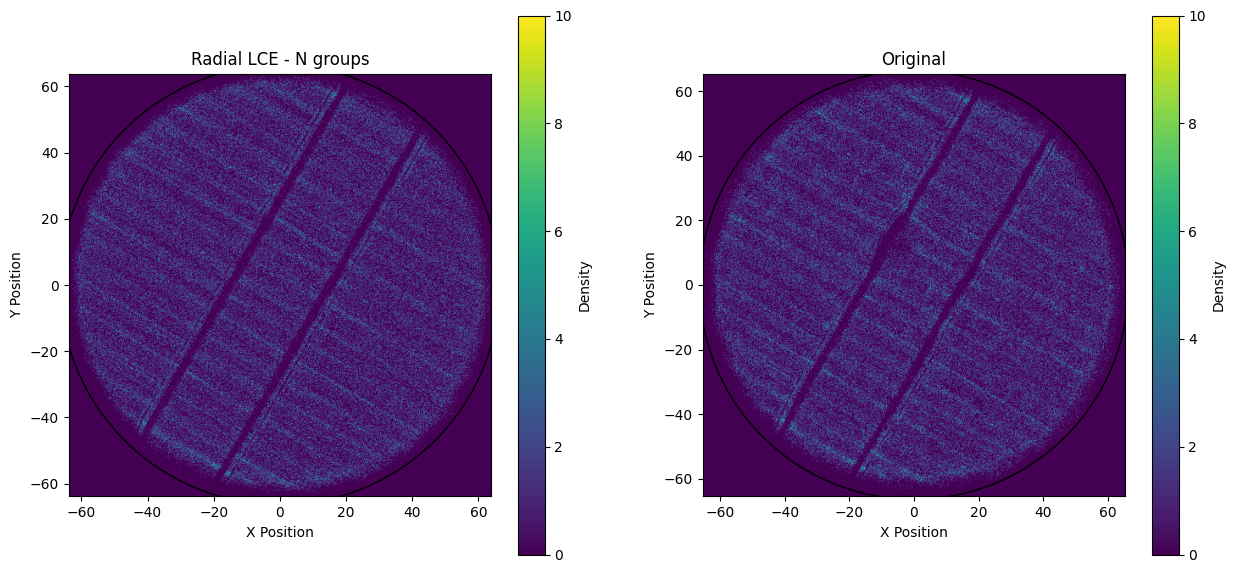

In [17]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

do_density_plot(ax[0],new_pos, title='Radial LCE - N groups', bins=500)
do_density_plot(ax[1],positions, title='Original', bins=500)
circle = plt.Circle((0, 0), tpc_radius, color='black', fill=False)
ax[0].add_patch(circle)
circle = plt.Circle((0, 0), tpc_radius, color='black', fill=False)
ax[1].add_patch(circle)

In [18]:
# New Median
tmp = keras_loss(patterns, radial_lce.predict(new_pos))
print(np.sort(tmp)[len(tmp)//2])

5652/5652 [==============================] - 47s 8ms/step
2.016554


## Train Neural LCE 

In [19]:
neural_lce = get_neural_LCE(n_pmts=not_dead_pmts.shape[0], 
                            pmt_pos=pmt_pos_top[not_dead_pmts,2:], 
                            I0_init=I0_init_from_ULCE, 
                            activation ='sigmoid', 
                            final_activation='sigmoid')
neural_lce.summary()

Model: "neural_lce"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 xy_to_pmt_coords (Sequenti  (None, 246, 6)            492       
 al)                                                             
                                                                 
 conv1d (Conv1D)             (None, 246, 60)           420       
                                                                 
 conv1d_1 (Conv1D)           (None, 246, 30)           1830      
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 15)           465       
                                                                 
 conv1d_3 (Conv1D)           (None, 246, 15)           240       
                                                        

In [21]:
early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,        
    restore_best_weights=True,
    min_delta=0.02,
    mode='min',    
    verbose=1      
)
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode = 'min',
    restore_best_weights=True,
    factor=0.25,           
    patience=2,            
    min_delta=0.03,        
    min_lr=1e-8,           
    verbose=1              
)
x_train_new_x = tensorflow.gather(new_pos,train_slice, axis = 0)
x_val_new_x =   tensorflow.gather(new_pos,val_slice, axis = 0)
# need non filtering loss function - radial LCE predicts arbitrary for dead as well
keras_loss_no_filter = logl_loss_generator(pmt_pos_top[not_dead_pmts], keras.backend, not_dead_pmts = None, cap=float('inf'), allow_njit=allow_njit)

neural_lce.compile(loss= keras_loss_no_filter, optimizer = keras.optimizers.Adam(learning_rate=10))

neural_lce.fit(x = x_train_new_x, y = y_train[:,not_dead_pmts], 
            validation_data=(x_val_new_x, val[1][:,not_dead_pmts]),
            epochs = 100, batch_size = 2**8, 
            callbacks=[early_stopping, reduce_lr])
val_loss, train_loss = plot_loss_histogram(neural_lce, (x_val_new_x, y_train[:,not_dead_pmts]), (val[0], val[1][:,not_dead_pmts]), ax=None, loss_func=keras_loss_no_filter, bins=1000,
                        title= "NN")

Epoch 1/100
566/566 [==============================] - 6s 10ms/step - loss: 60.0632 - val_loss: 59.9813 - lr: 10.0000
Epoch 2/100
324/566 [================>.............] - ETA: 1s - loss: 60.0299

KeyboardInterrupt: 

In [ ]:
nn_pos=train_and_update_pos(new_pos, patterns, neural_lce, n_iter = 4, verbose=1, hist_pos=False,keras_loss=keras_loss_no_filter)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

do_density_plot(ax[0],nn_pos, title='Radial LCE - N groups', bins=500)
do_density_plot(ax[1],positions, title='Original', bins=500)
circle = plt.Circle((0, 0), tpc_radius, color='black', fill=False)
ax[0].add_patch(circle)
circle = plt.Circle((0, 0), tpc_radius, color='black', fill=False)
ax[1].add_patch(circle)

In [ ]:
# New Median
tmp = keras_loss(patterns, radial_lce.predict(new_pos))
print(np.sort(tmp)[len(tmp)//2])